In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols

from mri_data import file_manager as fm

In [8]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = msmri_home / "monai_analysis" / "choroid_pineal_pituitary3"

## Data Cleaning

Load volume dataset

In [9]:
df_vols = pd.read_csv(curr_dir / "clinical_data_full.csv")
df_vols = df_vols.set_index("subid")
keep_cols = ["choroid_volume", "pineal_volume", "pituitary_volume", "tiv", "flair_contrast", "label", "scan_folder", "age"]

not_nas = (~df_vols['pineal_volume'].isna() & ~df_vols['choroid_volume'].isna() & ~df_vols['pituitary_volume'].isna())
df_vols = df_vols.loc[not_nas, keep_cols]

In [10]:
def subject_to_subid(subject):
    if not isinstance(subject, str):
        return None
    re_match = re.match(r"ms(\d{4})", subject)
    if re_match:
        return_val = int(re_match[1])
        return return_val
    else:
        return None

In [11]:
df_full = pd.read_csv(msmri_datadir / "Clinical_Data_All_updated.csv")
df_full.insert(0, "subid", df_full['ID'].map(subject_to_subid))
df_full = df_full.set_index("subid")

df = pd.merge(df_vols, df_full.loc[:, ~df_full.columns.isin(df_vols.columns)], how='outer', on='subid')

df.loc[:, 'extracted_EDSS'] = [float(val) if val != "." else None for val in df['extracted_EDSS']] #! figure out what to do with "."
df.loc[:, ['EDSS']] = pd.Categorical(df['extracted_EDSS'], ordered=True)
df.loc[df['PRL'] == "#VALUE!", 'PRL'] = None
df.loc[:, 'PRL'] = [int(val) if val != "#VALUE!" and val is not None else None for val in df['PRL']]
df.loc[df['dzdur'] == "#VALUE!", "dzdur"] = None

In [12]:
prl_levels = [range(0,1), range(1,3), range(3,5), range(5,df['PRL'].max()+1)]
df.loc[:, ['PRL_LEVEL']] = None
for i, level in enumerate(prl_levels):
    df.loc[df['PRL'].isin(level), ['PRL_LEVEL']] = i
df.loc[:, ['PRL_LEVEL']] = pd.Categorical(df['PRL_LEVEL'], ordered=True)

In [13]:
prl_levels = [range(0,1), range(1,3), range(3,df['PRL'].max()+1)]
df.loc[:, ['PRL_LEVEL']] = None
for i, level in enumerate(prl_levels):
    df.loc[df['PRL'].isin(level), ['PRL_LEVEL']] = i
df.loc[:, ['PRL_LEVEL']] = pd.Categorical(df['PRL_LEVEL'], ordered=True)

In [14]:
def check_nind(subtype):
    if "migraine" in subtype:
        return True
    elif "IIH" in subtype:
        return True
    elif "Migraine" in subtype:
        return True
    else:
        return False

In [15]:
def check_nind2(subtype):
    if type(subtype) is not str:
        return False
    keywords = ["migraine", "IIH", "anxiety", "Migraine"]
    for word in keywords:
        if word in subtype:
            return True
    return False

Add columns for volumes normalized by TIV

In [16]:
df.loc[:, ['norm_choroid_volume']] = df['choroid_volume']/df['tiv']
df.loc[:, ['norm_pineal_volume']] = df['pineal_volume']/df['tiv']
df.loc[:, ['norm_pituitary_volume']] = df['pituitary_volume']/df['tiv']

### Categorize Disease Types

- RMS vs MS vs !MS
- MS vs !MS
- MS vs OIND vs NIND

`dz_type` has relapsing MS (RMS) versus progressive MS (PMS) verusus not MS (!MS)

In [17]:
try:
    df.insert(18, 'dz_type', df['ms_type'])
except Exception:
    pass

df.loc[:, 'dz_type'] = df['ms_type']

df.loc[df['ms_type'].isin(['CIS', 'RRMS']), 'dz_type'] = 'RMS'
df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), 'dz_type'] = 'PMS'
df.loc[df['ms_type'].isin(['NIND', 'OIND', 'HC']), 'dz_type'] = '!MS'
# df.loc[(df['dz_type'] == "NIND") & (df['subtype'].map(check_nind2)), "dz_type"] = "HC"
print(df['dz_type'].unique())
print(sum(df['dz_type'] == "HC"))

['RMS' 'PMS' '!MS' 'UNK' 'RIS']
0


`dz_type2` has MS versus !MS and UNK

In [18]:
try:
    df.insert(18, 'dz_type2', df['dz_type'])
except Exception:
    pass

df.loc[:, 'dz_type2'] = df['dz_type']

df.loc[df['dz_type'].isin(['RMS', 'PMS']), 'dz_type2'] = 'MS'
df['dz_type2'].unique()

array(['MS', '!MS', 'UNK', 'RIS'], dtype=object)

`dz_type3` has MS v OIND v NIND

In [19]:
try:
    df.insert(18, 'dz_type3', df['ms_type'])
except Exception:
    pass

df.loc[:, 'dz_type3'] = df['ms_type']

df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS', 'RRMS', 'CIS']), 'dz_type3'] = 'MS'
df['dz_type3'].unique()

array(['MS', 'NIND', 'UNK', 'HC', 'OIND', 'RIS'], dtype=object)

`dz_type4`

In [20]:
try:
    df.insert(18, 'dz_type4', df['dz_type3'])
except Exception:
    pass

df.loc[:, 'dz_type4'] = df['dz_type3']

df.loc[(df['dz_type4'] == "NIND") & (df.loc[:, 'subtype'].map(check_nind2)), "dz_type4"] = "HC"

`dz_type5`

In [21]:
try:
    df.insert(18, 'dz_type5', df['ms_type'])
except Exception:
    pass

df.loc[:, 'dz_type5'] = df['ms_type']

df.loc[df['ms_type'].isin(['CIS', 'RRMS']), 'dz_type5'] = 'RMS'
df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), 'dz_type5'] = 'PMS'
print(df['dz_type5'].unique())
print(sum(df['dz_type5'] == "HC"))

['RMS' 'PMS' 'NIND' 'UNK' 'HC' 'OIND' 'RIS']
2


## Descriptive Stats

In [22]:
print(len(df), "patients in total")
nRMS = sum(df['dz_type'] == "RMS")
nPMS = sum(df['dz_type'] == "PMS")
nNotMS = sum(df['dz_type'] == "!MS")
print(nRMS, "patients with RMS", f"({round(nRMS / len(df), 2)})")
print(nPMS, "patients with PMS", f"({round(nPMS / len(df), 2)})")
print(nNotMS, "patients w/o MS", f"({round(nNotMS / len(df), 2)})")

564 patients in total
368 patients with RMS (0.65)
97 patients with PMS (0.17)
92 patients w/o MS (0.16)


In [23]:
print(len(df), "patients in total")
nMS = sum(df['dz_type3'] == "MS")
nOIND = sum(df['dz_type3'] == "OIND")
nNIND = sum(df['dz_type3'] == "NIND")
print(nMS, "patients with MS", f"({round(nMS / len(df), 2)})")
print(nOIND, "patients with OIND", f"({round(nOIND / len(df), 2)})")
print(nNIND, "patients w/o NIND", f"({round(nNIND / len(df), 2)})")

564 patients in total
465 patients with MS (0.82)
41 patients with OIND (0.07)
49 patients w/o NIND (0.09)


In [24]:
print("Female subjects:     {:0.2f}".format(sum(df['sex'] == "Female") / len(df)) )
print("Average age at scan: {:0.2f}".format(df['age'].mean()))

Female subjects:     0.79
Average age at scan: 47.58


In [25]:
df_rrms = df.loc[df["dz_type"] == "RMS"]
print("RMS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_rrms['sex'] == "Female") / len(df_rrms)))
print("\tAge:     {:0.2f}".format(df_rrms['age'].mean()))

df_pms = df.loc[df["dz_type"] == "PMS"]
print("PMS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_pms['sex'] == "Female") / len(df_pms)))
print("\tAge:     {:0.2f}".format(df_pms['age'].mean()))

df_notms = df.loc[df["dz_type"] == "!MS"]
print("!MS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_notms['sex'] == "Female") / len(df_notms)))
print("\tAge:     {:0.2f}".format(df_notms['age'].mean()))

RMS Patients:
	Female:  0.84
	Age:     44.54
PMS Patients:
	Female:  0.59
	Age:     58.25
!MS Patients:
	Female:  0.82
	Age:     49.05


#### Volumes

In [26]:
# choroid
print("Choroid volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms['choroid_volume'].mean()))
print("\tPMS:    {:0.2f}".format(df_pms['choroid_volume'].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms['choroid_volume'].mean()))

# pineal
print("Pineal volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms['pineal_volume'].mean()))
print("\tPMS:    {:0.2f}".format(df_pms['pineal_volume'].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms['pineal_volume'].mean()))

# pituitary
print("Pituitary volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms['pituitary_volume'].mean()))
print("\tPMS:    {:0.2f}".format(df_pms['pituitary_volume'].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms['pituitary_volume'].mean()))

Choroid volumes:
	RRMS:   1636.13
	PMS:    1686.45
	not-MS: 1759.73
Pineal volumes:
	RRMS:   181.47
	PMS:    150.11
	not-MS: 235.76
Pituitary volumes:
	RRMS:   631.39
	PMS:    640.51
	not-MS: 659.92


In [27]:
print("Choroid volumes:")
choroid_ms_mean = df[df['dz_type2'] == "MS"].choroid_volume.mean()
choroid_notms_mean = df[df['dz_type2'] == "!MS"].choroid_volume.mean()
print("\tMS:     {:0.2f}".format(choroid_ms_mean))
print("\tnot-MS: {:0.2f}".format(choroid_notms_mean))

print("\nPineal volumes")
pineal_ms_mean = df[df['dz_type2'] == "MS"].pineal_volume.mean()
pineal_notms_mean = df[df['dz_type2'] == "!MS"].pineal_volume.mean()
print("\tMS:     {:0.2f}".format(pineal_ms_mean))
print("\tnot-MS: {:0.2f}".format(pineal_notms_mean))

print("\nPituitary volumes")
pituitary_ms_mean = df[df['dz_type2'] == "MS"].pituitary_volume.mean()
pituitary_notms_mean = df[df['dz_type2'] == "!MS"].pituitary_volume.mean()
print("\tMS:     {:0.2f}".format(pituitary_ms_mean))
print("\tnot-MS: {:0.2f}".format(pituitary_notms_mean))

Choroid volumes:
	MS:     1646.40
	not-MS: 1759.73

Pineal volumes
	MS:     175.07
	not-MS: 235.76

Pituitary volumes
	MS:     633.25
	not-MS: 659.92


In [28]:
print("Choroid volumes:")
choroid_ms_mean = df[df['dz_type3'] == "MS"].choroid_volume.mean()
choroid_oind_mean = df[df['dz_type3'] == "OIND"].choroid_volume.mean()
choroid_nind_mean = df[df['dz_type3'] == "NIND"].choroid_volume.mean()
print("\tMS:   {:0.2f}".format(choroid_ms_mean))
print("\tOIND: {:0.2f}".format(choroid_oind_mean))
print("\tNIND: {:0.2f}".format(choroid_nind_mean))


print("\nPineal volumes")
pineal_ms_mean = df[df['dz_type2'] == "MS"].pineal_volume.mean()
pineal_oind_mean = df[df['dz_type3'] == "OIND"].pineal_volume.mean()
pineal_nind_mean = df[df['dz_type3'] == "NIND"].pineal_volume.mean()
print("\tMS:   {:0.2f}".format(pineal_ms_mean))
print("\tOIND: {:0.2f}".format(pineal_oind_mean))
print("\tNIND: {:0.2f}".format(pineal_nind_mean))


print("\nPituitary volumes")
pituitary_ms_mean = df[df['dz_type2'] == "MS"].pituitary_volume.mean()
pituitary_oind_mean = df[df['dz_type3'] == "OIND"].pituitary_volume.mean()
pituitary_nind_mean = df[df['dz_type3'] == "NIND"].pituitary_volume.mean()
print("\tMS:   {:0.2f}".format(pituitary_ms_mean))
print("\tOIND: {:0.2f}".format(pituitary_oind_mean))
print("\tNIND: {:0.2f}".format(pituitary_nind_mean))

Choroid volumes:
	MS:   1646.40
	OIND: 1752.60
	NIND: 1795.19

Pineal volumes
	MS:   175.07
	OIND: 205.06
	NIND: 263.55

Pituitary volumes
	MS:   633.25
	OIND: 646.75
	NIND: 667.03


## Plots

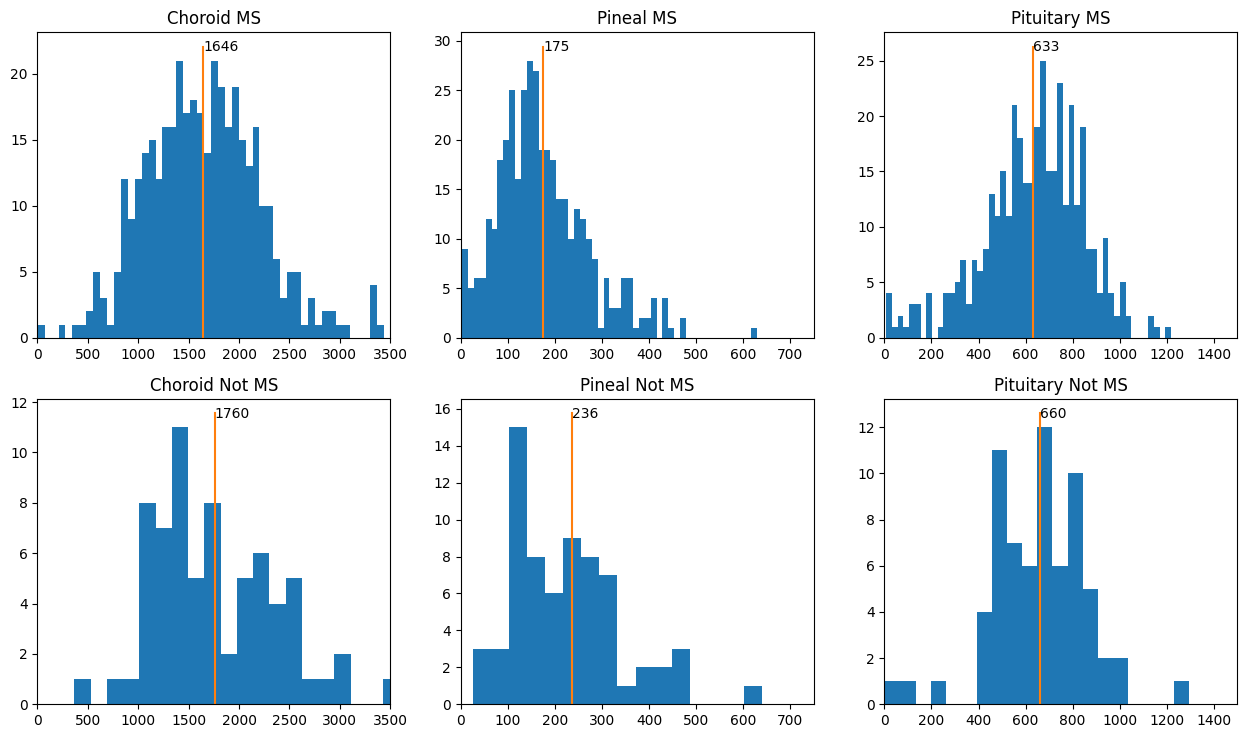

In [29]:
fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df.loc[df['dz_type2']=='MS', 'choroid_volume'], bins=50)
ax[0,0].set_xlim([0, 3500])
ax[0,0].set_title("Choroid MS")
ax[0,0].plot([choroid_ms_mean, choroid_ms_mean], ax[0,0].get_ylim())
text_y = ax[0,0].get_ylim()[1] - ax[0,0].get_ylim()[1] / 16
ax[0,0].text(choroid_ms_mean, text_y, "{:0.0f}".format(choroid_ms_mean))

ax[1, 0].hist(df.loc[df['dz_type2']=='!MS', 'choroid_volume'], bins=20)
ax[1, 0].set_xlim([0, 3500])
ax[1, 0].set_title("Choroid Not MS")
ax[1,0].plot([choroid_notms_mean, choroid_notms_mean], ax[1,0].get_ylim())
text_y = ax[1,0].get_ylim()[1] - ax[1,0].get_ylim()[1] / 16
ax[1,0].text(choroid_notms_mean, text_y, "{:0.0f}".format(choroid_notms_mean))


ax[0,1].hist(df.loc[df['dz_type2']=='MS', 'pineal_volume'], bins=50)
ax[0,1].set_xlim([0, 750])
ax[0,1].set_title("Pineal MS")
ax[0,1].plot([pineal_ms_mean, pineal_ms_mean], ax[0,1].get_ylim())
text_y = ax[0,1].get_ylim()[1] - ax[0,1].get_ylim()[1] / 16
ax[0,1].text(pineal_ms_mean, text_y, "{:0.0f}".format(pineal_ms_mean))

ax[1,1].hist(df.loc[df['dz_type2']=='!MS', 'pineal_volume'], bins=30)
ax[1,1].set_xlim([0, 750])
ax[1,1].set_title("Pineal Not MS")
ax[1,1].plot([pineal_notms_mean, pineal_notms_mean], ax[1,1].get_ylim())
text_y = ax[1,1].get_ylim()[1] - ax[1,1].get_ylim()[1] / 16
ax[1,1].text(pineal_notms_mean, text_y, "{:0.0f}".format(pineal_notms_mean))


ax[0,2].hist(df.loc[df['dz_type2']=='MS', 'pituitary_volume'], bins=50)
ax[0,2].set_xlim([0, 1500])
ax[0,2].set_title("Pituitary MS")
ax[0,2].plot([pituitary_ms_mean, pituitary_ms_mean], ax[0,2].get_ylim())
text_y = ax[0,2].get_ylim()[1] - ax[0,2].get_ylim()[1] / 16
ax[0,2].text(pituitary_ms_mean, text_y, "{:0.0f}".format(pituitary_ms_mean))

ax[1,2].hist(df.loc[df['dz_type2']=='!MS', 'pituitary_volume'], bins=20)
ax[1,2].set_xlim([0, 1500])
ax[1,2].set_title("Pituitary Not MS")
ax[1,2].plot([pituitary_notms_mean, pituitary_notms_mean], ax[1,2].get_ylim())
text_y = ax[1,2].get_ylim()[1] - ax[1,2].get_ylim()[1] / 16
ax[1,2].text(pituitary_notms_mean, text_y, "{:0.0f}".format(pituitary_notms_mean))

plt.subplots_adjust(bottom=0.1, right=2, top=1.5)

## Regression Models

Covariates: age, sex, TIV, contrast

### Linear Regression on Volume

Predict volume of structure with the following predictors:

- MS vs Not-MS
- MS vs OIND vs NIND
- RMS vs PMS

#### Choroid Plexus

##### MS vs not-MS

In [30]:
volume = 'choroid_volume'

data = df[['dz_type2', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type2'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type2']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Male', 'tiv', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     10.39
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           4.63e-08
Time:                        13:57:00   Log-Likelihood:                -3510.6
No. Observations:                 455   AIC:                             7031.
Df Residuals:                     450   BIC:                             7052.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            8.2262      2.066      3.982      0.0

##### MS vs NIND vs OIND

In [31]:
volume = 'choroid_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     10.23
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           6.53e-08
Time:                        13:57:00   Log-Likelihood:                -3277.9
No. Observations:                 425   AIC:                             6566.
Df Residuals:                     420   BIC:                             6586.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            8.0538      2.121      3.798      0.0

##### PMS v RMS

In [32]:
volume = 'choroid_volume'

data = df[['dz_type5', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, "PRL_LEVEL", "lesion_vol_cubic"]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type5'].isin(['RMS', 'PMS', 'NIND', 'OIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type5']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'RMS', 'PMS', 'OIND', 'intercept']
# predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     7.148
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           2.73e-07
Time:                        13:57:00   Log-Likelihood:                -3494.6
No. Observations:                 453   AIC:                             7003.
Df Residuals:                     446   BIC:                             7032.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            9.1363      2.252      4.057      0.0

Alternative to dummy coding, using R style formula

In [33]:
volume = 'choroid_volume'

data = df[['dz_type', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, "PRL_LEVEL", "lesion_vol_cubic"]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type'].isin(['RMS', 'PMS', 'NIND', 'OIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data['sex_male'] = data.sex.map({'Female': 0, 'Male': 1})

fit = ols('volume ~ C(sex_male) + C(dz_type) + age + tiv', data=data).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     8.787
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           8.55e-07
Time:                        13:57:00   Log-Likelihood:                -2972.2
No. Observations:                 386   AIC:                             5954.
Df Residuals:                     381   BIC:                             5974.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -28.5674    396.10

In [34]:
volume = 'choroid_volume'

data = df[['dz_type4', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, "PRL_LEVEL", "lesion_vol_cubic"]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type4'].isin(['MS', 'HC'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type4']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

# predictors = ['age', 'Female', 'tiv', 'RMS', 'PMS', 'PRL_LEVEL', 'lesion_vol_cubic', 'intercept']
predictors = ['age', 'Female', 'tiv', 'MS', 'lesion_vol_cubic', 'PRL_LEVEL', 'intercept']
res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     6.650
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           1.04e-06
Time:                        13:57:00   Log-Likelihood:                -3047.9
No. Observations:                 396   AIC:                             6110.
Df Residuals:                     389   BIC:                             6138.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  6.5949      2.374  

#### Pineal

##### MS vs not-MS

Note: this is significant for MS vs Not-MS, but not when adding disease duration as a covariate

In [35]:
volume = 'pineal_volume'

data = df[['dz_type2', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, 'PRL_LEVEL', 'lesion_vol_cubic']]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type2'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type2']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Male', 'tiv', 'WITH', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     6.896
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           3.24e-06
Time:                        13:57:00   Log-Likelihood:                -2772.3
No. Observations:                 455   AIC:                             5557.
Df Residuals:                     449   BIC:                             5581.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.7129      0.409     -1.744      0.0

##### MS vs NIND vs OIND

Note: this is significant for MS vs Not-MS, but not when adding disease duration as a covariate

In [36]:
volume = 'pineal_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'OIND', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'WITH', 'MS', 'OIND', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     6.908
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           4.96e-07
Time:                        13:57:00   Log-Likelihood:                -2757.4
No. Observations:                 453   AIC:                             5529.
Df Residuals:                     446   BIC:                             5558.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.7451      0.409     -1.821      0.0

##### PMS v RMS

In [37]:
volume = 'pineal_volume'

data = df[['dz_type5', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, 'PRL_LEVEL', 'lesion_vol_cubic']]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type5'].isin(['RMS', 'PMS', 'NIND', 'OIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type5']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
predictors = ['age', 'Female', 'tiv', 'RMS', 'PMS', 'OIND', 'PRL_LEVEL', 'lesion_vol_cubic', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     4.679
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           1.63e-05
Time:                        13:57:00   Log-Likelihood:                -2753.6
No. Observations:                 452   AIC:                             5525.
Df Residuals:                     443   BIC:                             5562.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -0.3197      0.480  

#### Pituitary

##### MS vs not-MS

In [38]:
volume = 'pituitary_volume'

data = df[['dz_type2', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type2'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type2']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Male', 'tiv', 'WITH', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     7.687
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           5.98e-07
Time:                        13:57:00   Log-Likelihood:                -3061.9
No. Observations:                 455   AIC:                             6136.
Df Residuals:                     449   BIC:                             6160.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.1320      0.772     -0.171      0.8

##### MS vs NIND vs OIND

In [39]:
volume = 'pituitary_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'OIND', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'WITH', 'MS', 'OIND', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     6.449
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           1.56e-06
Time:                        13:57:00   Log-Likelihood:                -3048.9
No. Observations:                 453   AIC:                             6112.
Df Residuals:                     446   BIC:                             6141.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.1503      0.779     -0.193      0.8

##### PMS v RMS

In [40]:
volume = 'pituitary_volume'

data = df[['dz_type5', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, 'PRL_LEVEL', 'lesion_vol_cubic']]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type5'].isin(['RMS', 'PMS', 'OIND', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type5']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
predictors = ['age', 'Female', 'tiv', 'RMS', 'PMS', 'OIND', 'PRL_LEVEL', 'lesion_vol_cubic', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7954
Date:                Thu, 30 Jan 2025   Prob (F-statistic):              0.607
Time:                        13:57:00   Log-Likelihood:                -3056.7
No. Observations:                 452   AIC:                             6131.
Df Residuals:                     443   BIC:                             6168.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.8170      0.940  

### Ordinal Regression on EDSS

Predict EDSS score using volumes. Use MS vs OIND vs NIND as covariate (in addition to the others)

In [41]:
data = df[
    [
        "dz_type3",
        "dz_type",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "extracted_EDSS",
        "ARMSS",
        "PRL_LEVEL",
        "lesion_vol_cubic",
        "MSSS",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
        "thalamus",
        "brain",
        "cortical_thickness",
        "dzdur"
    ]
]
data = data[data["dz_type3"].isin(["MS"])]
data.loc[:, ["dz_type3_factor"]], _ = data["dz_type3"].factorize(sort=False)

data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]
# df['extracted_EDSS'] = df['extracted_EDSS'] * 2
data.loc[data["extracted_EDSS"] == ".", "extracted_EDSS"] = None
# data['extracted_EDSS'] = pd.Categorical(data['extracted_EDSS'], ordered=True)

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

# predictors = ['age', 'Female', 'tiv', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']
# predictors = ['age', 'Female', 'tiv', 'RMS', 'PRL_LEVEL', 'lesion_vol_cubic', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']

predictors = [
    "age",
    "Female",
    "tiv",
    "PRL_LEVEL",
    "lesion_vol_cubic",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "dzdur",
    "intercept",
]

data = data.dropna()

# mod = OrderedModel(data2['numEDSS'],
#                    data2[predictors].astype('float'), distr='probit', disp=False)
# res = mod.fit(method='nm')

res = sm.OLS(
    data["extracted_EDSS"].astype("float"), data[predictors].astype("float")
).fit(missing="drop")

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         extracted_EDSS   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     12.95
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           8.23e-18
Time:                        13:57:00   Log-Likelihood:                -690.70
No. Observations:                 355   AIC:                             1401.
Df Residuals:                     345   BIC:                             1440.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0427      0.010  

In [42]:
data = df[['dz_type3', 'dz_type', 'age', 'sex', 'tiv', 'flair_contrast', 'extracted_EDSS', 'ARMSS', 'PRL_LEVEL', "lesion_vol_cubic",
           'MSSS', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness']]
data = data[data['dz_type3'].isin(['MS'])]
data.loc[:, ['dz_type3_factor']], _ = data['dz_type3'].factorize(sort=False)

data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]
# df['extracted_EDSS'] = df['extracted_EDSS'] * 2
data.loc[data['extracted_EDSS'] == ".", "extracted_EDSS"] = None
# data['extracted_EDSS'] = pd.Categorical(data['extracted_EDSS'], ordered=True)

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

# predictors = ['age', 'Female', 'tiv', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']
predictors = ['age', 'Female', 'tiv', 'RMS', 'PRL_LEVEL', 'lesion_vol_cubic', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']

data = data.dropna()

# mod = OrderedModel(data2['numEDSS'], 
#                    data2[predictors].astype('float'), distr='probit', disp=False)
# res = mod.fit(method='nm')

res = sm.OLS(data['MSSS'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSSS   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     7.153
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           1.14e-11
Time:                        13:57:00   Log-Likelihood:                -782.73
No. Observations:                 355   AIC:                             1591.
Df Residuals:                     342   BIC:                             1642.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
age                   -0.0184      0

### JASP Data

In [44]:
columns = [
    "dz_type",
    "dz_type2",
    "dz_type3",
    "dz_type4",
    "dz_type5",
    "age",
    "sex",
    "tiv",
    "flair_contrast",
    "extracted_EDSS",
    "ARMSS",
    "PRL_LEVEL",
    "lesion_vol_cubic",
    "MSSS",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "thalamus",
    "brain",
    "cortical_thickness",
    "dzdur"
]
df_jasp = df[columns]
df_jasp = pd.concat((
    df_jasp,
    pd.get_dummies(df_jasp['sex'])),
    axis=1
)
df_jasp = df_jasp.loc[df_jasp['dzdur'] != ".", :]

for i, row in df_jasp.iterrows():
    if row['Female']:
        df_jasp.loc[i, 'Female'] = 1
    else:
        df_jasp.loc[i, 'Female'] = 0
    
    if row['Male']:
        df_jasp.loc[i, 'Male'] = 1
    else:
        df_jasp.loc[i, 'Male'] = 0

/tmp/ipykernel_315672/1750535439.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_jasp.loc[i, 'Female'] = 1
/tmp/ipykernel_315672/1750535439.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_jasp.loc[i, 'Male'] = 0


In [45]:
jasp_dir = curr_dir / "jasp_data"

df_jasp.to_csv(jasp_dir / "dataframe.csv")

In [46]:
df['dz_type3'].unique()

array(['MS', 'NIND', 'UNK', 'HC', 'OIND', 'RIS'], dtype=object)

In [47]:
df_jasp3 = df_jasp[df_jasp['dz_type3'].isin(["MS", "NIND", "OIND"])]
df_jasp5 = df_jasp[df_jasp['dz_type5'].isin(["RMS", "PMS", "NIND", "OIND"])]
df_jasp_ms = df_jasp[df_jasp['dz_type5'].isin(["RMS", "PMS"])]

df_jasp3.to_csv(jasp_dir / "dataframe3.csv")
df_jasp5.to_csv(jasp_dir / "dataframe5.csv")
df_jasp_ms.to_csv(jasp_dir / "dataframeMS.csv")